## Condensed

In [2]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication
from torchvision.models import vgg16_bn

from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading

In [4]:
# fileDir = "C:/fully_split_data/"
# t1MapDir = "C:/T1_Maps/"
fileDir = "/media/storage/chill/fully_split_data/"
t1MapDir = "/media/storage/chill/T1_Maps/"

modelName = "Not_Norm_Condense_20000_Cardiov"
condense = True
bSize = 12
normQ = False

modelDir = "./models/DCGAN_ESQ/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

[Errno 17] File exists: './models/VGG_16/Not_Norm_Condense_20000_Cardiov/Test_Figures/' This means you will be overwriting previous results!


In [5]:
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]




 Loading Meta Data.... 

 [31199/31199]


In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

net = vgg16_bn(pretrained=False)
numFtrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(numFtrs,outSize)
numChannels = net.features[0].out_channels
net.features[0] = nn.Conv2d(7, numChannels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
net.load_state_dict(modelDict["state_dict"])
net = net.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

In [9]:
pred = np.zeros((testLen,outSize))
y_test = np.zeros((testLen,outSize))
with torch.no_grad():
    net.eval()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        out = net(inpData)

        out = torch.sigmoid(out)

        pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4996/5000

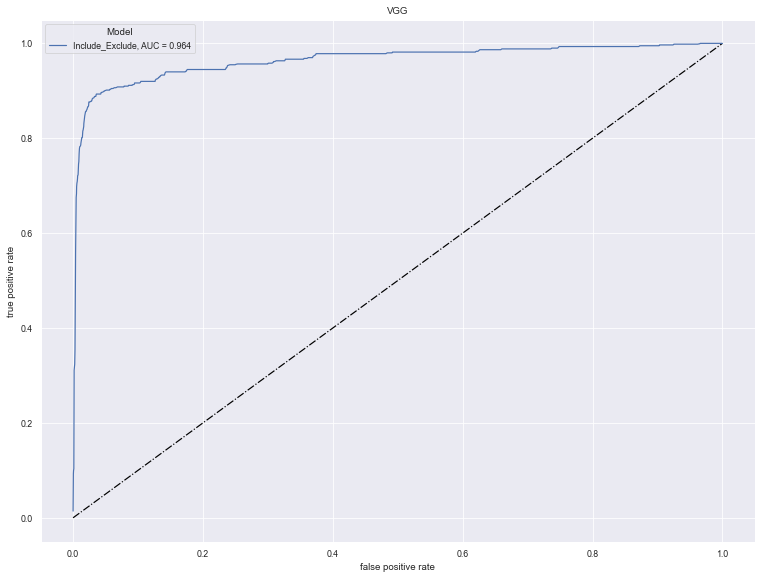

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

# tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("VGG")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

## Not Condensed

In [1]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication

from models import DCGAN_ESG
from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading
from train_utils import get_device_metrics

In [2]:
# fileDir = "C:/fully_split_data/"
# t1MapDir = "C:/T1_Maps/"
fileDir = "/media/storage/chill/fully_split_data/"
t1MapDir = "/media/storage/chill/T1_Maps/"

modelName = "Not_Norm_20000_Cardiov"
normQ = False

modelDir = "./models/DCGAN_ESQ/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

[Errno 17] File exists: './models/DCGAN_ESQ/Not_Norm_20000_Cardiov/Test_Figures/' This means you will be overwriting previous results!


In [3]:
condense = False
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=5000,transform=trnsInTest,load=True,condense=condense)



 Loading Meta Data.... 

 [31199/31199]


In [6]:
bSize = 16
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

In [7]:
deviceMetrics, sugDev = get_device_metrics(memLimit=3000)

device = torch.device(sugDev if torch.cuda.is_available() else "cpu")

print("Running on device: {}".format(device))

net = DCGAN_ESG(inpMetaSize,7,7,outSize)
net = net.to(device)

modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
net.load_state_dict(modelDict["state_dict"])
net = net.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

Running on device: cuda:1


In [8]:
pred = np.zeros((testLen,outSize))
y_test = np.zeros((testLen,outSize))
with torch.no_grad():
    net.eval()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        if inpData.size()[2:] == (288,384):
            eid = data["eid"]
            inpMeta = data["Meta"].to(device)
            y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

            out = net(inpData,inpMeta)

            out = torch.sigmoid(out)

            pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4992/5000

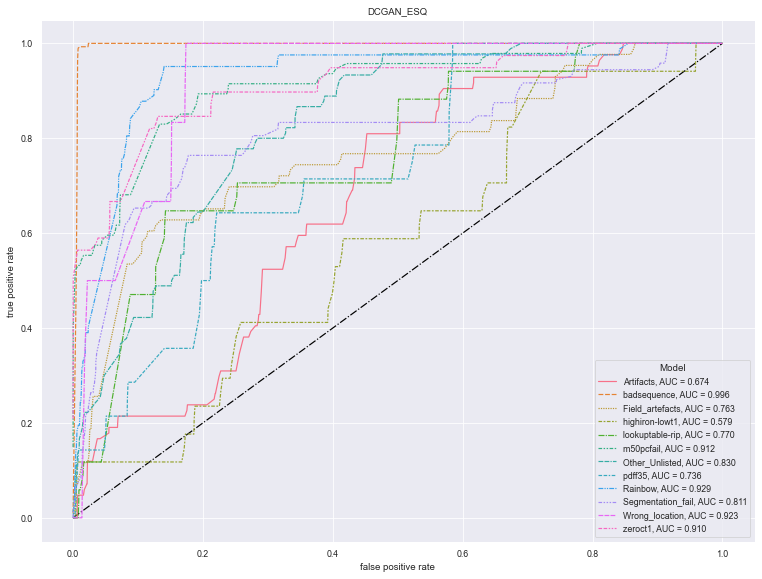

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("DCGAN_ESQ")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

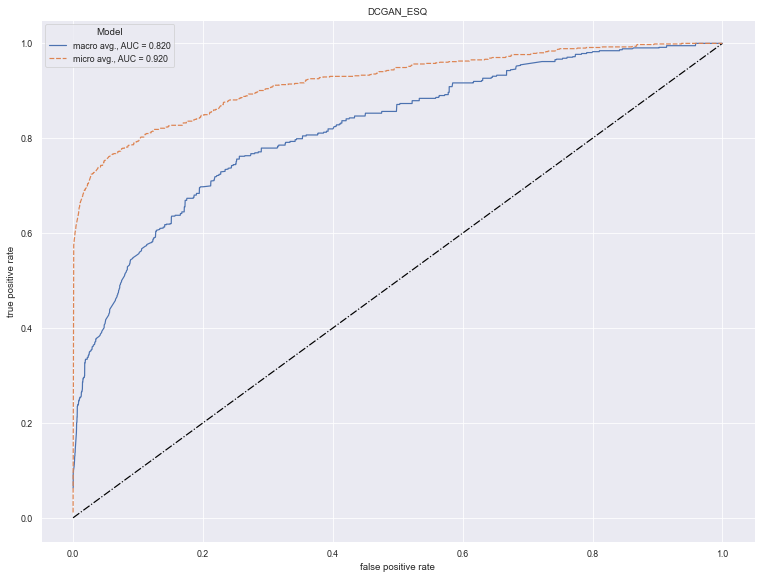

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test[:,i],pred[:,i])
    rocDict[name] = roc_auc_score(y_test[:,i],pred[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += np.interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test.ravel(),pred.ravel())
auc_score = roc_auc_score(y_test.ravel(),pred.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("DCGAN_ESQ")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

## Normalised Not Condensed

In [1]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication
from torchvision.models import vgg16_bn

from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading
from train_utils import get_device_metrics

In [2]:
# fileDir = "C:/fully_split_data/"
# t1MapDir = "C:/T1_Maps/"
fileDir = "/media/storage/chill/fully_split_data/"
t1MapDir = "/media/storage/chill/T1_Maps/"

modelName = "Norm_20000_Cardiov"
normQ = True

modelDir = "./models/VGG_16/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

In [3]:
condense = False
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)


 Loading Meta Data.... 

 [31199/31199]


In [4]:
bSize = 2
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

In [5]:
deviceMetrics, sugDev = get_device_metrics()

device = torch.device(sugDev if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print("Running on device: {}".format(device))

net = vgg16_bn(pretrained=False)
numFtrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(numFtrs,outSize)
numChannels = net.features[0].out_channels
net.features[0] = nn.Conv2d(7, numChannels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
net.load_state_dict(modelDict["state_dict"])
net = net.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

Running on device: cuda:0


In [6]:
pred = np.zeros((testLen,outSize))
y_test = np.zeros((testLen,outSize))
with torch.no_grad():
    net.eval()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        out = net(inpData)

        out = torch.sigmoid(out)

        pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4998/5000

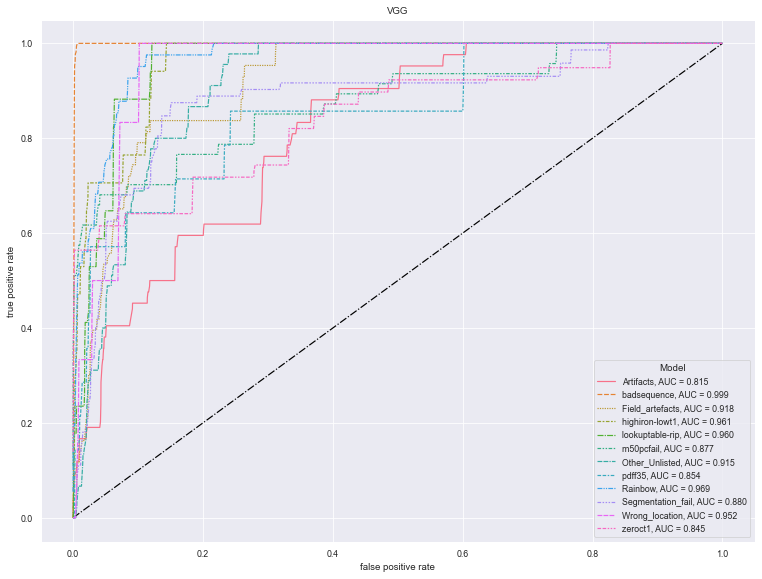

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("VGG")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

/home/chill/Meta_T1/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


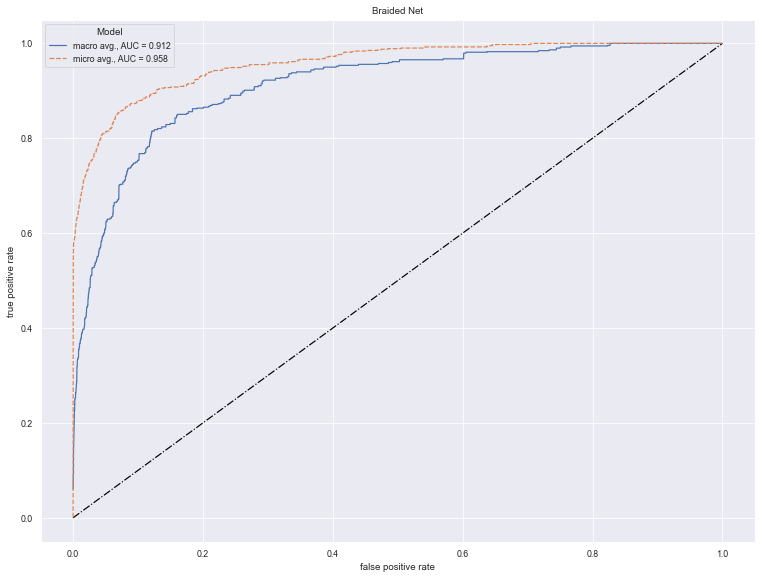

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test[:,i],pred[:,i])
    rocDict[name] = roc_auc_score(y_test[:,i],pred[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test.ravel(),pred.ravel())
auc_score = roc_auc_score(y_test.ravel(),pred.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Braided Net")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()